# Basics

Importing the datasets

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c covid-segmentation
!unzip \*.zip && rm *.zip

 99% 149M/150M [00:01<00:00, 114MB/s]
100% 150M/150M [00:01<00:00, 123MB/s]
  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 88.8MB/s]
 65% 9.00M/13.9M [00:00<00:00, 80.4MB/s]
100% 13.9M/13.9M [00:00<00:00, 89.0MB/s]
100% 315M/316M [00:02<00:00, 131MB/s]
100% 316M/316M [00:02<00:00, 130MB/s]
  0% 0.00/563k [00:00<?, ?B/s]
100% 563k/563k [00:00<00:00, 183MB/s]
Archive:  test_images_medseg.npy.zip
  inflating: test_images_medseg.npy  

Archive:  images_radiopedia.npy.zip
  inflating: images_radiopedia.npy   

Archive:  masks_radiopedia.npy.zip
  inflating: masks_radiopedia.npy    

Archive:  masks_medseg.npy.zip
  inflating: masks_medseg.npy        

Archive:  images_medseg.npy.zip
  inflating: images_medseg.npy       

5 archives were successfully processed.


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models
!git clone https://github.com/SlinkoIgor/ImageDataAugmentor.git

import segmentation_models as sm
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-n0kutt79
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-n0kutt79
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=6e80ae3e0e92d9fff94ad2f76545bb720214a6b0ad0eb5f1a720b520ebc06c6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-j2peqvx0/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 310, done.
remote: Total 310 (delta 0), reused 0 (delta 0), pack-reused 310
Receiving objects: 100% (310/310), 131.62 KiB | 1.73 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Segmentation Models: using `keras` framework.


In [ ]:
prefix = '/content'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)



Function for viewing images and their corresponding masks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

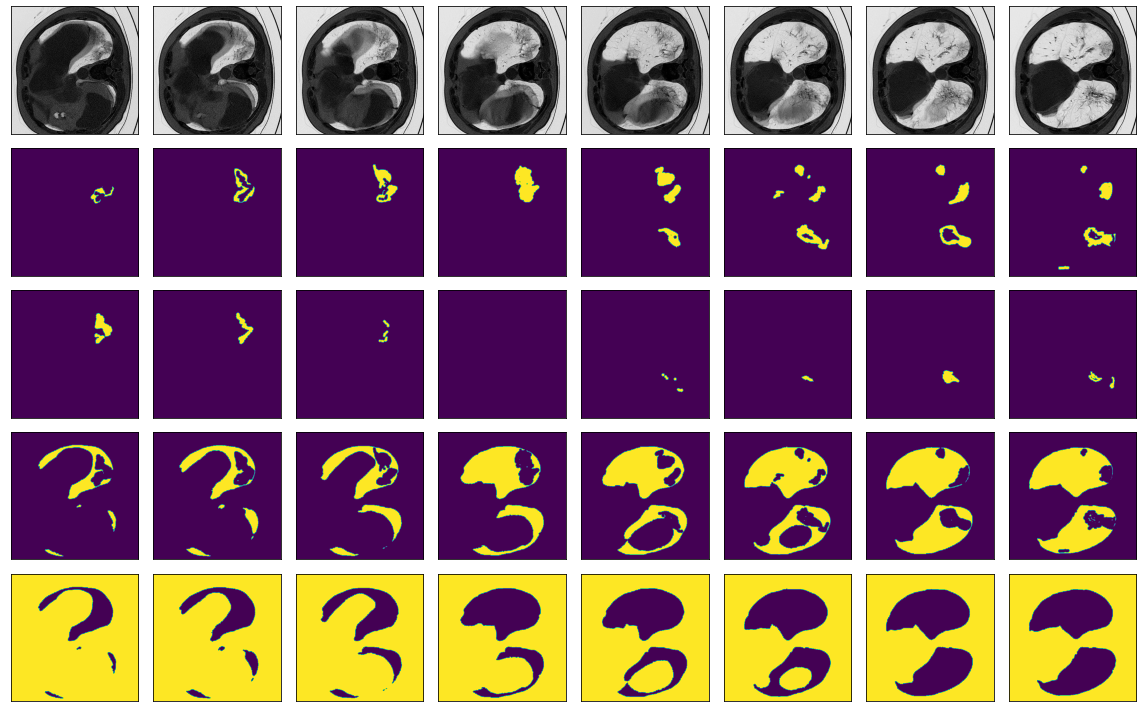

In [ ]:
visualize(images_radiopedia[12:], masks_radiopedia[12:])

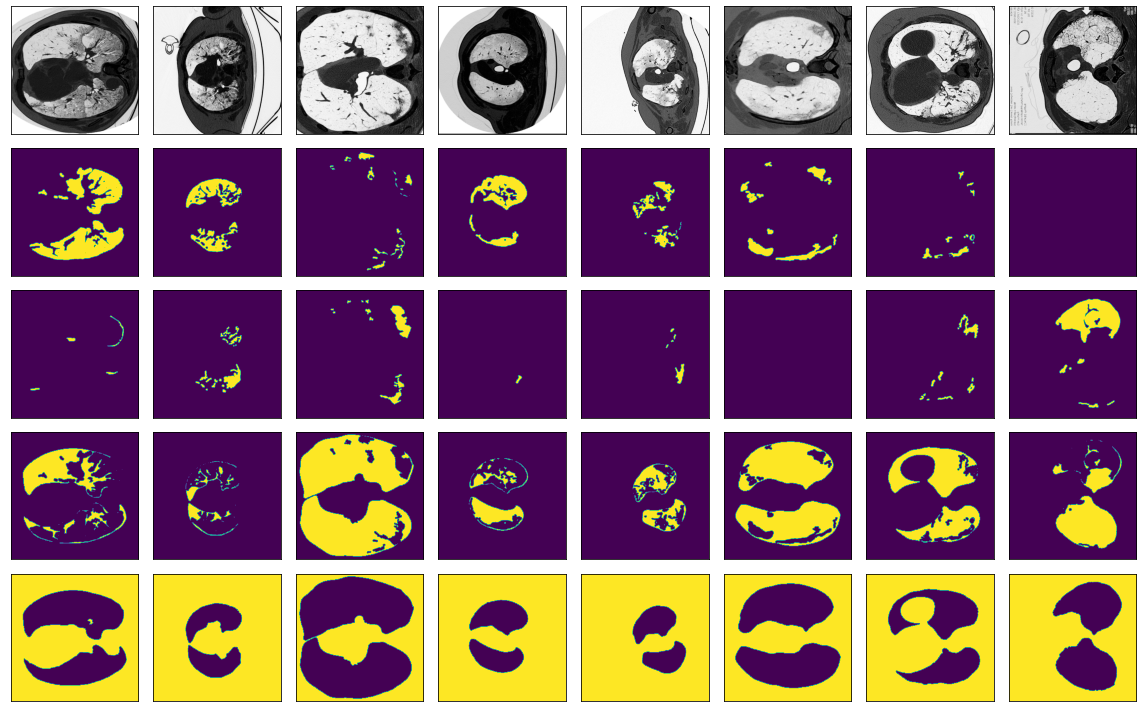

In [ ]:
visualize(images_medseg[8:], masks_medseg[8:])

In [ ]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)


mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


In [ ]:
print(images_radiopedia.shape)
print(images_medseg.shape)

(829, 512, 512, 1)
(100, 512, 512, 1)


In [ ]:
test_indexes, val_indexes, train_indexes = list(range(15)), list(range(16,30)), list(range(31, 100))
test_indexes_r, val_indexes_r, train_indexes_r = list(range(125)), list(range(126, 250)), list(range(251, 829))

train_m= images_medseg[train_indexes]
train_r=images_radiopedia[train_indexes_r]
train_m_masks = masks_medseg[train_indexes]
train_r_masks = masks_radiopedia[train_indexes_r]


val_m= images_medseg[val_indexes]
val_r=images_radiopedia[val_indexes_r]

val_m_masks = masks_medseg[val_indexes]
val_r_masks =masks_radiopedia[val_indexes_r]


test_m= images_medseg[test_indexes]
test_r=images_radiopedia[test_indexes_r]
test_m_masks = masks_medseg[test_indexes]
test_r_masks = masks_radiopedia[test_indexes_r]


print(train_m.shape, train_r.shape)
print(val_m.shape, val_r.shape)
print(test_m.shape, test_r.shape)

train_images = np.concatenate((train_m, train_r),axis=0)
val_images = np.concatenate((val_m, val_r),axis=0)
test_images = np.concatenate((test_m, test_r),axis=0)

train_masks = np.concatenate((train_m_masks, train_r_masks),axis=0)
val_masks = np.concatenate((val_m_masks, val_r_masks),axis=0)
test_masks = np.concatenate((test_m_masks, test_r_masks),axis=0)


# train_masks = np.concatenate(masks_radiopedia)
print(train_images.shape)


(69, 512, 512, 1) (578, 512, 512, 1)
(14, 512, 512, 1) (124, 512, 512, 1)
(15, 512, 512, 1) (125, 512, 512, 1)
(647, 512, 512, 1)


In [ ]:
batch_size = 16

Data generator and augmentations

In [ ]:
import tensorflow

import albumentations
import cv2

SOURCE_SIZE = 512
TARGET_SIZE = 256

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),
    # albumentations.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    # albumentations.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
    # IAAAdditiveGaussianNoise(p=0.2)
])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [ ]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)
test_dataset = Dataset(test_images, test_masks, val_augs)


train_dataloader = Dataloder(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = Dataloder(test_dataset,batch_size=batch_size, shuffle=False)

check shape for errors

In [ ]:
assert train_dataloader[0][0].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 1)
assert train_dataloader[0][1].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 4)

  dataloader

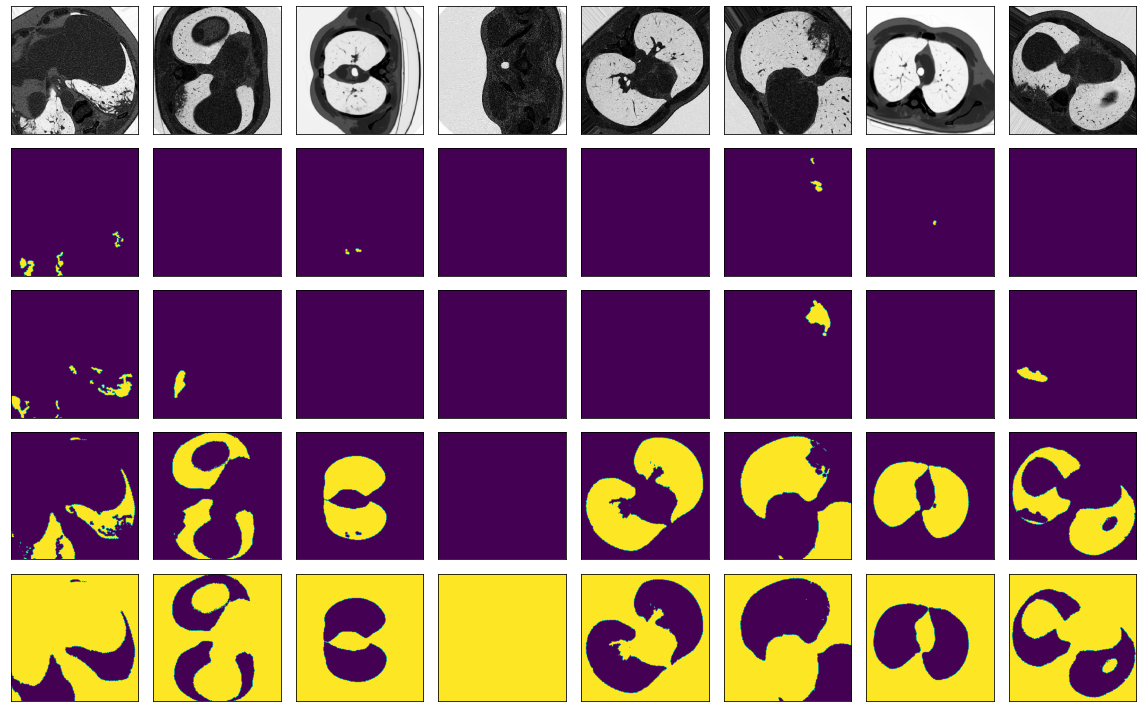

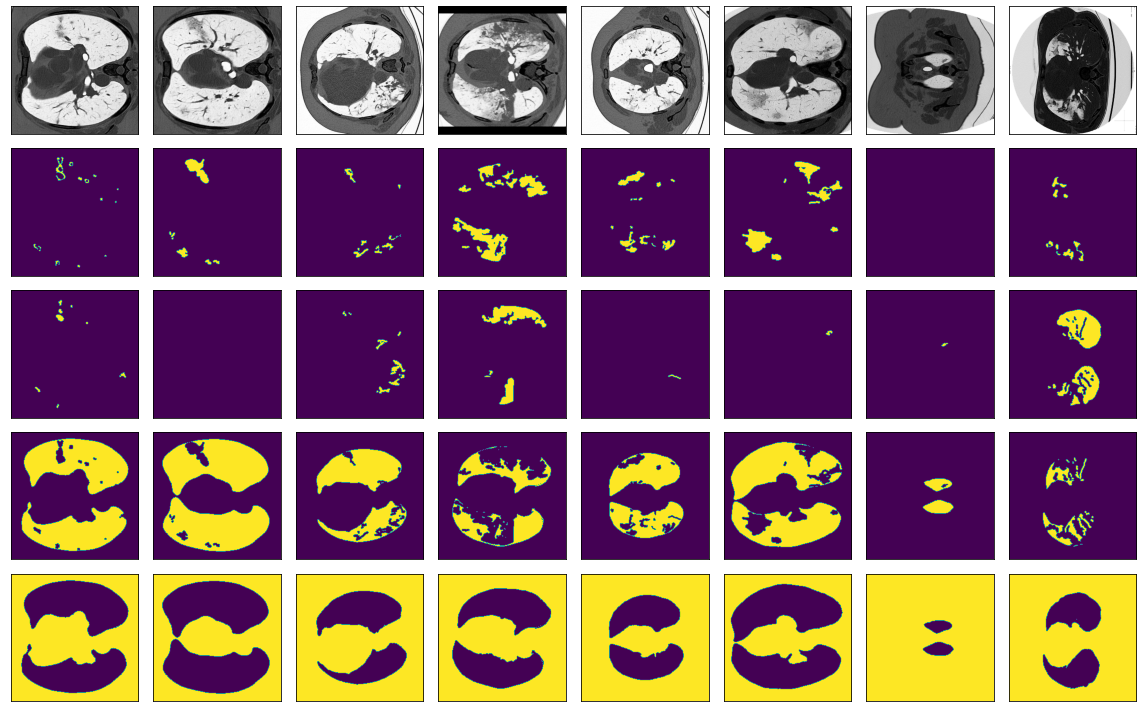

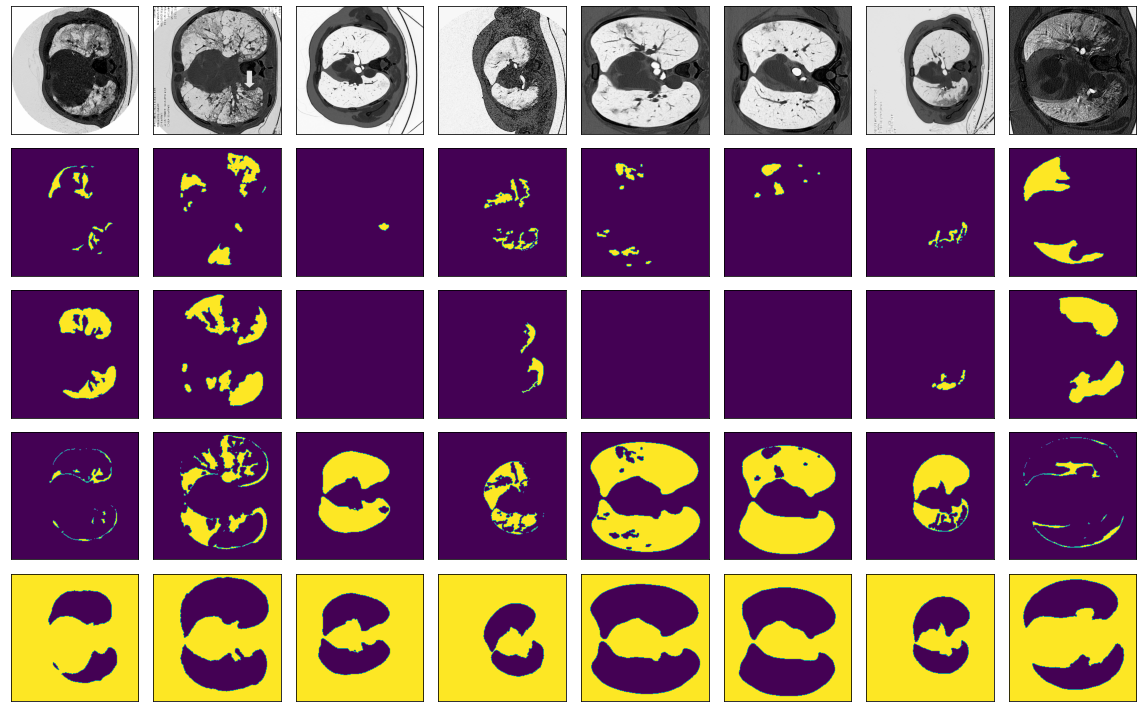

In [ ]:
visualize(*next(iter(train_dataloader)))
visualize(*next(iter(val_dataloader)))
visualize(*next(iter(test_dataloader)))

# Linknet + EfficientNet B3

Model define

In [ ]:
from segmentation_models import Linknet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Linknet(backbone_name='efficientnetb3',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

44122112/44107200 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 3)       6         
                                                                 
 model (Functional)          (None, None, None, 4)     17868268  
                                                                 
Total params: 17,868,274
Trainable params: 17,778,994
Non-trainable params: 89,280
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/Linknet/CSV/K-Linknet-EfficientnetB3.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 45s 1s/step - loss: 0.0257 - iou_score: 0.4902 - f1-score: 0.5070 - val_loss: 0.0625 - val_iou_score: 0.6652 - val_f1-score: 0.6853 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 46s 1s/step - loss: 0.0205 - iou_score: 0.5812 - f1-score: 0.6297 - val_loss: 0.0646 - val_iou_score: 0.6676 - val_f1-score: 0.6931 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 45s 1s/step - loss: 0.0178 - iou_score: 0.5916 - f1-score: 0.6386 - val_loss: 0.0704 - val_iou_score: 0.6261 - val_f1-score: 0.6635 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 44s 1s/step - loss: 0.0166 - iou_score: 0.5966 - f1-score: 0.6432 - val_loss: 0.0222 - val_iou_score: 0.7422 - val_f1-score: 0.7786 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 45s 1s/step - loss: 0.0159 - iou_score: 0.6031 - f1-score: 0.6501 - val_loss: 0.1487 - val_iou_score: 0.4992 - val_f1-score: 0.5368 - lr: 0.0010
Epoch 6/10

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.009019
mean iou_score: 0.8063
mean f1-score: 0.87912


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.007359
mean iou_score: 0.85089
mean f1-score: 0.88424


Plots

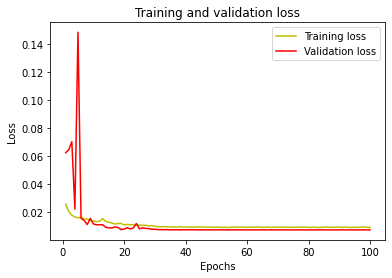

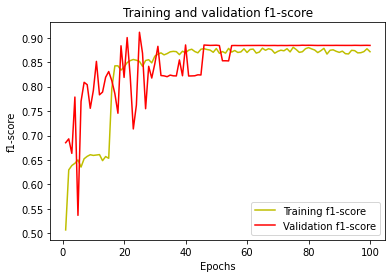

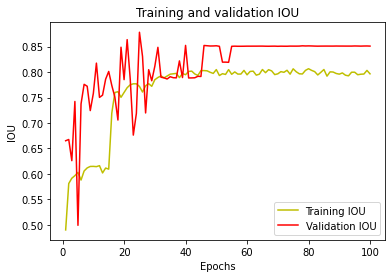

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.018589
mean iou_score: 0.66325
mean f1-score: 0.73677


In [ ]:
print(scores_test)

[0.01858888939023018, 0.6632493734359741, 0.7367743849754333]


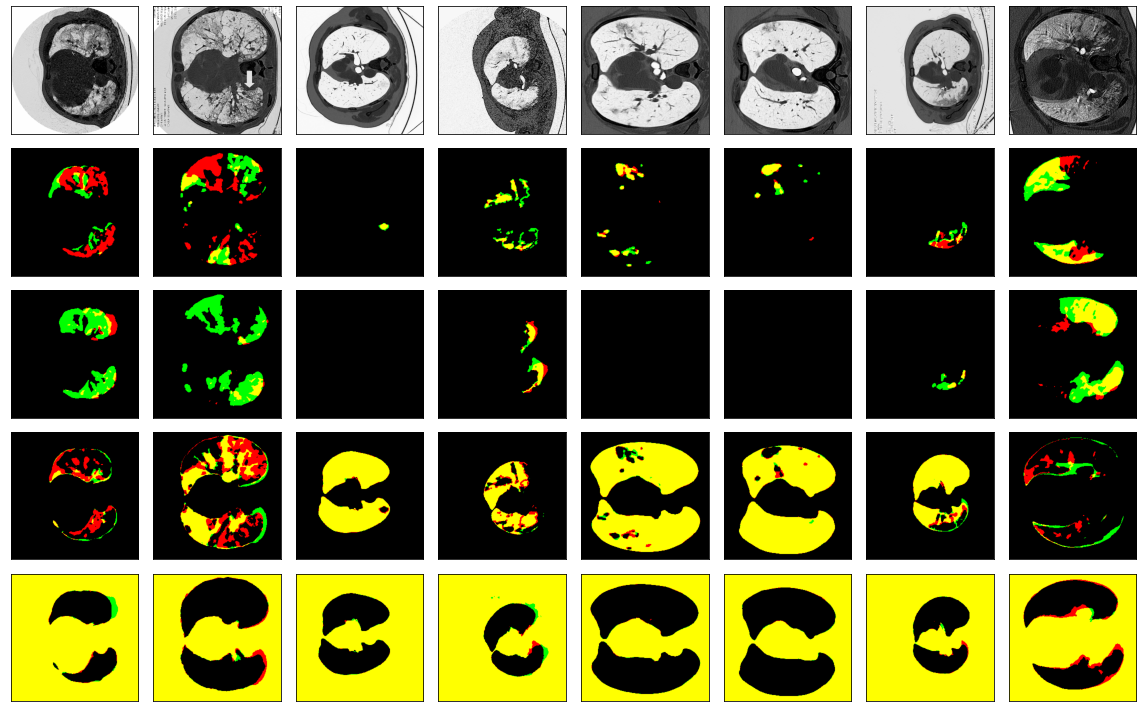

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# Linknet + VGG19

Model define

In [ ]:
from segmentation_models import Linknet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Linknet(backbone_name='vgg19',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

80150528/80134624 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 3)       6         
                                                                 
 model_1 (Functional)        (None, None, None, 4)     29062404  
                                                                 
Total params: 29,062,410
Trainable params: 29,058,378
Non-trainable params: 4,032
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-vgg19.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/Linknet/CSV/K-Linknet-vgg19.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 55s 1s/step - loss: 0.1338 - iou_score: 0.4072 - f1-score: 0.4382 - val_loss: 0.0446 - val_iou_score: 0.6618 - val_f1-score: 0.6827 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 39s 975ms/step - loss: 0.0332 - iou_score: 0.4694 - f1-score: 0.4839 - val_loss: 0.0321 - val_iou_score: 0.6639 - val_f1-score: 0.6843 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 41s 1s/step - loss: 0.0323 - iou_score: 0.4683 - f1-score: 0.4832 - val_loss: 0.1184 - val_iou_score: 0.5934 - val_f1-score: 0.6221 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 39s 974ms/step - loss: 0.0266 - iou_score: 0.4739 - f1-score: 0.4864 - val_loss: 0.0250 - val_iou_score: 0.6700 - val_f1-score: 0.6884 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 39s 976ms/step - loss: 0.0233 - iou_score: 0.4778 - f1-score: 0.4885 - val_loss: 0.0200 - val_iou_score: 0.6783 - val_f1-score: 0.6949 - lr: 0.0010
E

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.010836
mean iou_score: 0.77094
mean f1-score: 0.84933


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.010344
mean iou_score: 0.73954
mean f1-score: 0.77621


Plots

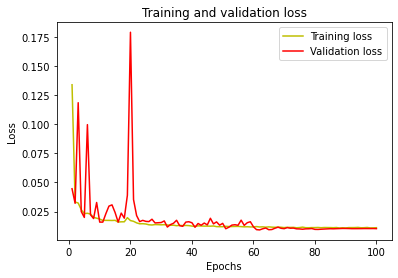

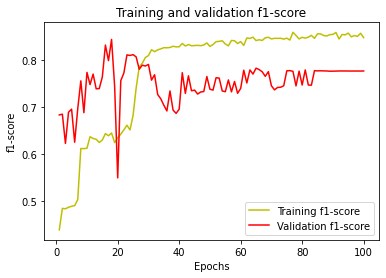

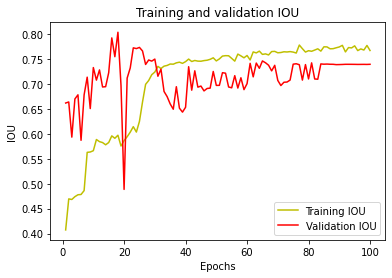

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.021789
mean iou_score: 0.61055
mean f1-score: 0.68245


In [ ]:
print(scores_test)

[0.021789396181702614, 0.6105529069900513, 0.6824537515640259]


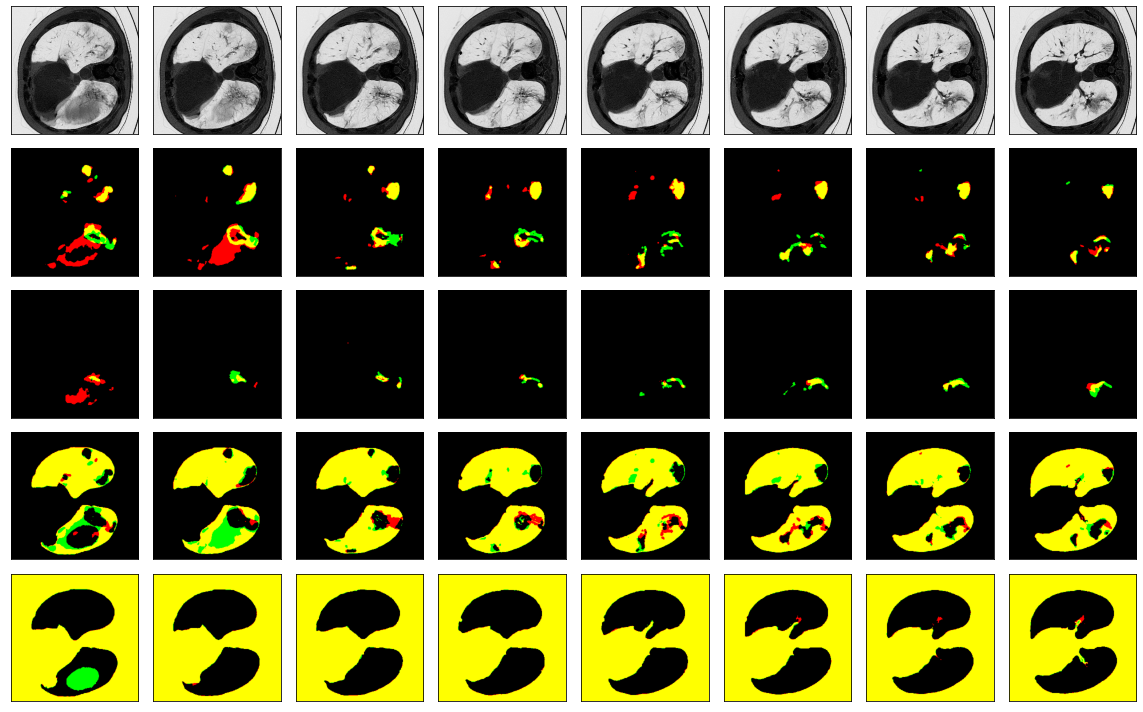

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# Linknet + Inceptionresnet V2

Model define

In [ ]:
from segmentation_models import Linknet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Linknet(backbone_name='inceptionresnetv2',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 256, 256, 3)       6         
                                                                 
 model (Functional)          (None, None, None, 4)     57869156  
                                                                 
Total params: 57,869,162
Trainable params: 57,802,058
Non-trainable params: 67,104
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-inceptionresnetv2.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/Linknet/CSV/K-Linknet-inceptionresnetv2.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 127s 2s/step - loss: 0.1642 - iou_score: 0.3975 - f1-score: 0.4287 - val_loss: 0.3766 - val_iou_score: 0.3217 - val_f1-score: 0.3391 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 61s 2s/step - loss: 0.0333 - iou_score: 0.4714 - f1-score: 0.4850 - val_loss: 0.1688 - val_iou_score: 0.5723 - val_f1-score: 0.6155 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 59s 1s/step - loss: 0.0262 - iou_score: 0.4752 - f1-score: 0.4871 - val_loss: 0.1498 - val_iou_score: 0.5355 - val_f1-score: 0.5627 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 61s 2s/step - loss: 0.0224 - iou_score: 0.4782 - f1-score: 0.4887 - val_loss: 0.0413 - val_iou_score: 0.6604 - val_f1-score: 0.6843 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 59s 1s/step - loss: 0.0209 - iou_score: 0.4803 - f1-score: 0.4898 - val_loss: 0.0447 - val_iou_score: 0.6569 - val_f1-score: 0.6819 - lr: 0.0010
Epoch 6/1

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0090952
mean iou_score: 0.80043
mean f1-score: 0.8729


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0074064
mean iou_score: 0.81651
mean f1-score: 0.84968


Plots

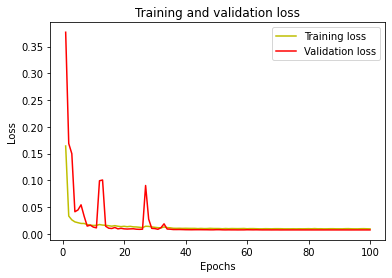

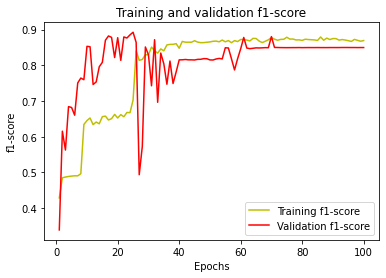

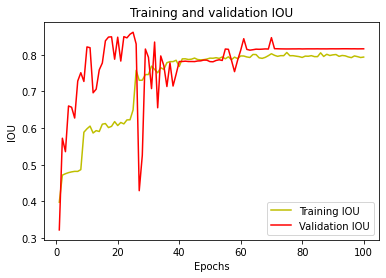

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.020183
mean iou_score: 0.67662
mean f1-score: 0.74796


In [ ]:
print(scores_test)

[0.02018282189965248, 0.676619827747345, 0.7479621767997742]


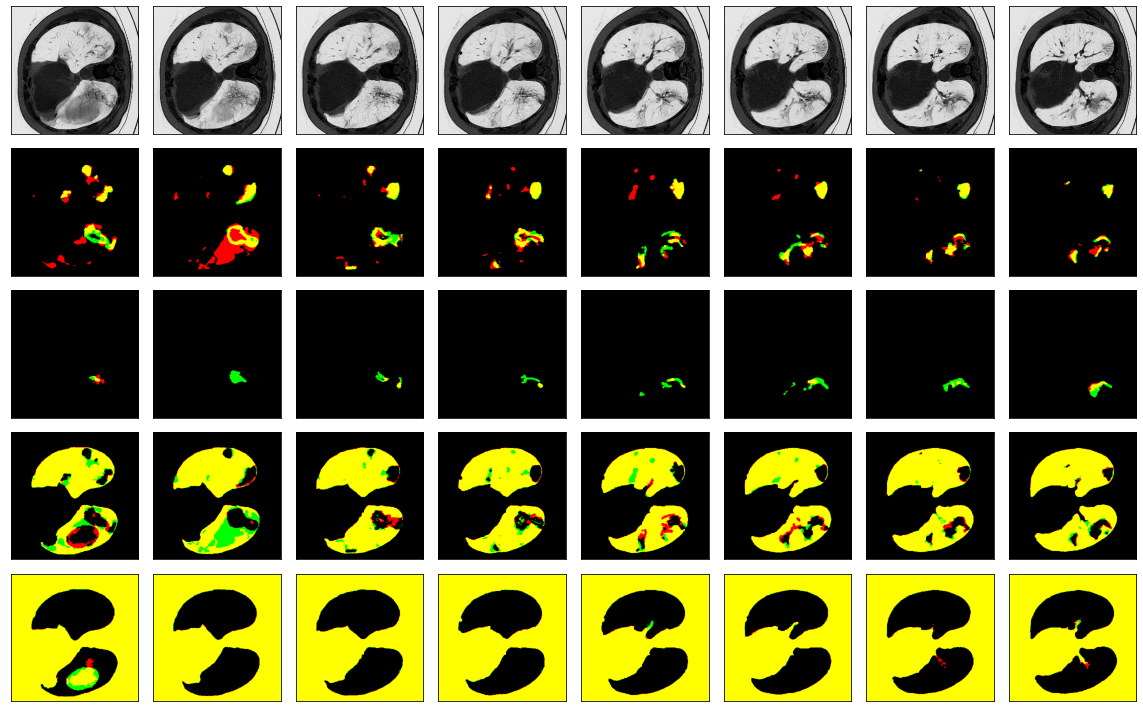

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# Linknet + Densenet 121

Model define

In [ ]:
from segmentation_models import Linknet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Linknet(backbone_name='densenet121',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_206 (Conv2D)         (None, 256, 256, 3)       6         
                                                                 
 model_1 (Functional)        (None, None, None, 4)     8355140   
                                                                 
Total params: 8,355,146
Trainable params: 8,267,562
Non-trainable params: 87,584
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-densenet121.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/Linknet/CSV/K-Linknet-densenet121.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 54s 851ms/step - loss: 0.2304 - iou_score: 0.3351 - f1-score: 0.3695 - val_loss: 1.8421 - val_iou_score: 0.3824 - val_f1-score: 0.4383 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 31s 776ms/step - loss: 0.0410 - iou_score: 0.4638 - f1-score: 0.4807 - val_loss: 0.1724 - val_iou_score: 0.5658 - val_f1-score: 0.5780 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 30s 756ms/step - loss: 0.0317 - iou_score: 0.4754 - f1-score: 0.4899 - val_loss: 0.0699 - val_iou_score: 0.6127 - val_f1-score: 0.6498 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 31s 757ms/step - loss: 0.0271 - iou_score: 0.4728 - f1-score: 0.4857 - val_loss: 0.0394 - val_iou_score: 0.7066 - val_f1-score: 0.7356 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 31s 760ms/step - loss: 0.0230 - iou_score: 0.4777 - f1-score: 0.4885 - val_loss: 0.0275 - val_iou_score: 0.7060 - val_f1-score: 0.7250 - lr: 0.

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.011022
mean iou_score: 0.77846
mean f1-score: 0.85841


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0084032
mean iou_score: 0.77468
mean f1-score: 0.81083


Plots

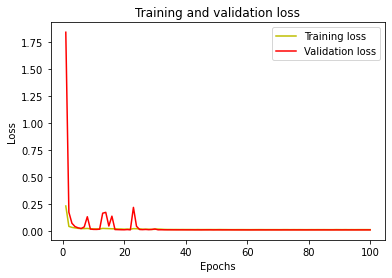

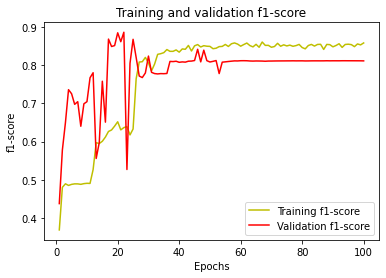

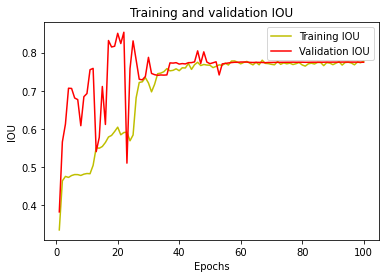

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.020762
mean iou_score: 0.60446
mean f1-score: 0.67733


In [ ]:
print(scores_test)

[0.0207623653113842, 0.6044645309448242, 0.6773338317871094]


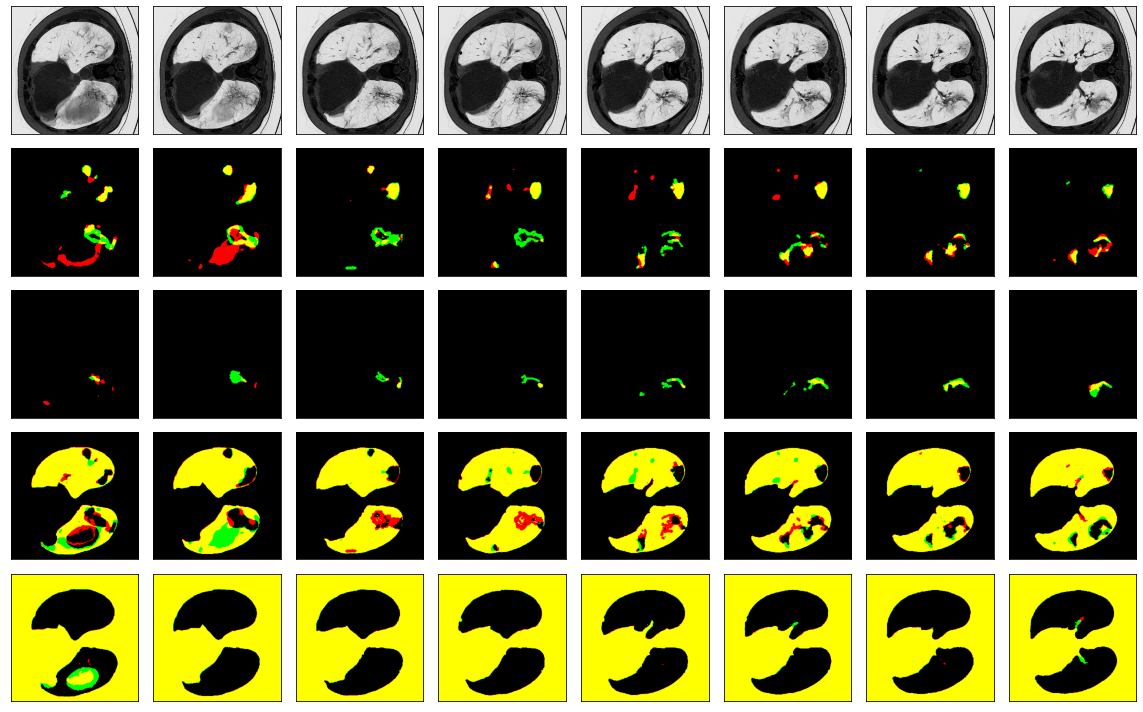

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# Linknet + Mobilenet V2

Model define

In [ ]:
from segmentation_models import Linknet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Linknet(backbone_name='mobilenetv2',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_208 (Conv2D)         (None, 256, 256, 3)       6         
                                                                 
 model_2 (Functional)        (None, None, None, 4)     4145012   
                                                                 
Total params: 4,145,018
Trainable params: 4,106,570
Non-trainable params: 38,448
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-mobilenetv2.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/Linknet/CSV/K-Linknet-mobilenetv2.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 36s 585ms/step - loss: 0.1945 - iou_score: 0.3741 - f1-score: 0.4090 - val_loss: 3.4951 - val_iou_score: 0.3187 - val_f1-score: 0.3462 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 22s 537ms/step - loss: 0.0342 - iou_score: 0.4740 - f1-score: 0.4864 - val_loss: 1.3302 - val_iou_score: 0.4500 - val_f1-score: 0.5118 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 22s 536ms/step - loss: 0.0245 - iou_score: 0.4767 - f1-score: 0.4878 - val_loss: 0.2380 - val_iou_score: 0.5646 - val_f1-score: 0.6050 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 22s 539ms/step - loss: 0.0213 - iou_score: 0.4800 - f1-score: 0.4897 - val_loss: 0.0470 - val_iou_score: 0.7169 - val_f1-score: 0.7417 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 22s 536ms/step - loss: 0.0188 - iou_score: 0.4826 - f1-score: 0.4910 - val_loss: 0.0562 - val_iou_score: 0.6951 - val_f1-score: 0.7234 - lr: 0.

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0090095
mean iou_score: 0.81438
mean f1-score: 0.88593


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0075291
mean iou_score: 0.81275
mean f1-score: 0.84803


Plots

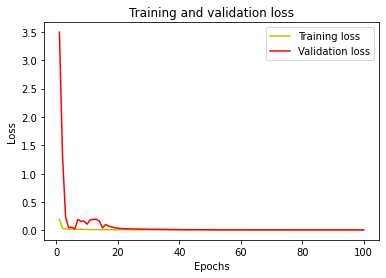

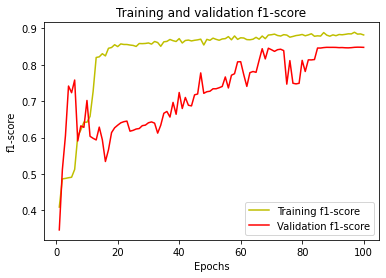

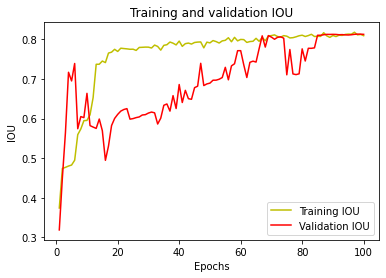

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.020585
mean iou_score: 0.65291
mean f1-score: 0.72839


In [ ]:
print(scores_test)

[0.020585112273693085, 0.65291428565979, 0.7283935546875]


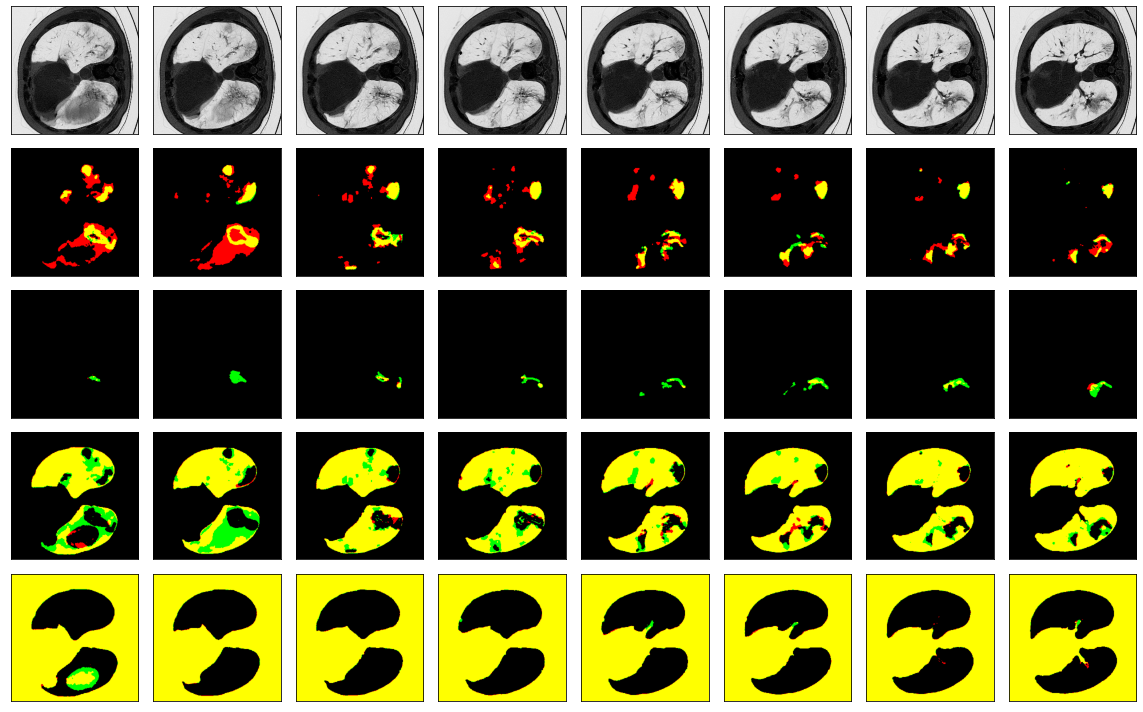

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# Linknet + Seresnext 101

Model define

In [ ]:
from segmentation_models import Linknet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Linknet(backbone_name='seresnext101',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Linknet-seresnext101.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/Unet/CSV/K-Linknet-seresnext101.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 100s 2s/step - loss: 0.1890 - iou_score: 0.3702 - f1-score: 0.4005 - val_loss: 0.3233 - val_iou_score: 0.2869 - val_f1-score: 0.3053 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 61s 2s/step - loss: 0.0337 - iou_score: 0.4739 - f1-score: 0.4864 - val_loss: 0.0456 - val_iou_score: 0.6599 - val_f1-score: 0.6844 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 61s 2s/step - loss: 0.0257 - iou_score: 0.4764 - f1-score: 0.4877 - val_loss: 0.1067 - val_iou_score: 0.6733 - val_f1-score: 0.7055 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 65s 2s/step - loss: 0.0233 - iou_score: 0.4851 - f1-score: 0.4953 - val_loss: 0.3807 - val_iou_score: 0.5055 - val_f1-score: 0.5196 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 61s 2s/step - loss: 0.0208 - iou_score: 0.4810 - f1-score: 0.4902 - val_loss: 0.0524 - val_iou_score: 0.7271 - val_f1-score: 0.7497 - lr: 0.0010
Epoch 6/1

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0093883
mean iou_score: 0.80215
mean f1-score: 0.87661


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0076357
mean iou_score: 0.74524
mean f1-score: 0.77963


Plots

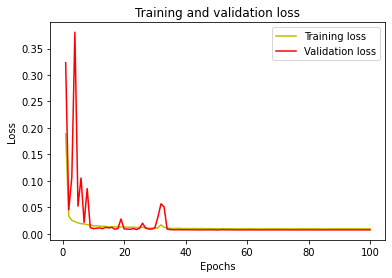

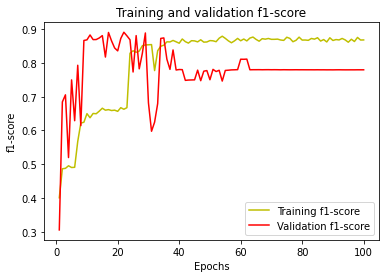

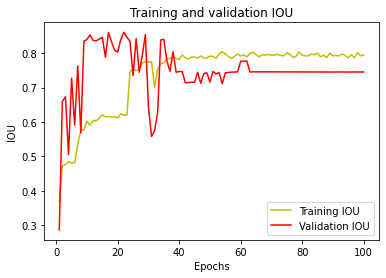

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.019381
mean iou_score: 0.66201
mean f1-score: 0.7363


In [ ]:
print(scores_test)

[0.019380824640393257, 0.6620149612426758, 0.7363004684448242]


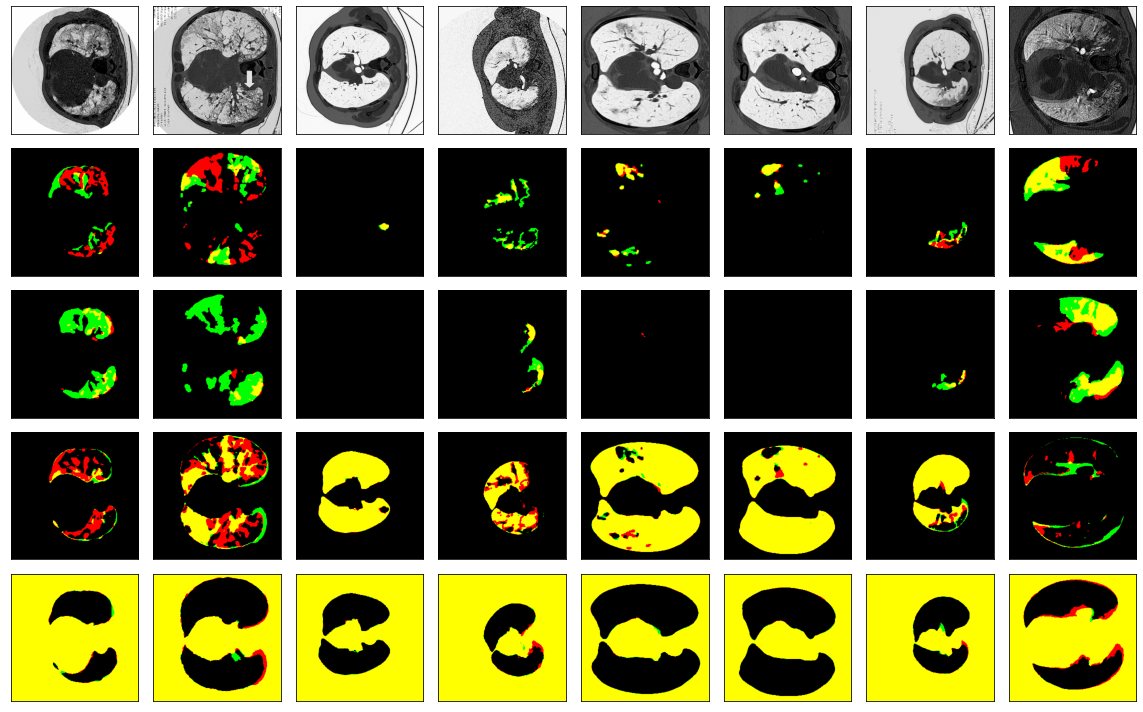

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN